In [2]:
import numpy as np 
import pandas as pd
import string
from tqdm import tqdm
import math
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import  hstack
# from handFeaturesV6 import hand_features, clean, get_tokenized_lemmas, remove_stopwords
import matplotlib.pyplot as plt
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.stem import WordNetLemmatizer
from numpy import triu
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, concatenate,Flatten,LSTM, Embedding, Input,Dropout
from keras.models import Model
# from WF_gw2v_embedding import gw2v_sentence_embeddings
from keras.callbacks import ModelCheckpoint
import os
import re
import nltk
import string
import numpy as np
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from tqdm import tqdm


_wnl = nltk.WordNetLemmatizer()

2024-08-15 06:41:14.817693: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-15 06:41:15.786334: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-15 06:41:16.170596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 06:41:16.675648: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 06:41:16.868054: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-15 06:41:17.889107: I tensorflow/core/platform/cpu_feature_gu

In [5]:
from nltk.tokenize import word_tokenize
def normalize_word(w):
    return _wnl.lemmatize(w).lower()


def get_tokenized_lemmas(s):
    return [normalize_word(t) for t in word_tokenize(s)]


def clean(text):
    # Cleans a string: Lowercasing, trimming, removing non-alphanumeric
    text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation),''))
    return " ".join(re.findall(r'\w+', text, flags=re.UNICODE)).lower()


def remove_stopwords(l):
    # Removes stopwords from a list of tokens
    return [w for w in l if w not in ENGLISH_STOP_WORDS]

def join_tok(text):
    return " ".join(text).lower()

In [6]:
def process(texts):
    lst=[]
    for text in tqdm(texts):
        clean_text= clean(text)
        tok_text= get_tokenized_lemmas(clean_text)
        remov_stp= remove_stopwords(tok_text)
        lst.append(join_tok(remov_stp))
    return lst

In [7]:
data= pd.read_csv('../../Data/clickBait_Data.csv')

In [8]:
data.head()

,index,id,titles,clickbait
0,27375,27376,Dolphins held in captivity escape from Japanes...,0
1,38706,38707,See Me Now: the show exposing the everyday liv...,0
2,2071,2072,The 17 Most Mind-Blowing Maps They Never Taug...,1
3,11962,11963,White House refusal to release Trump tax retur...,0
4,13521,13522,Heroism aboard the sinking Clytoneus | Letters,0


In [9]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
_wnl = WordNetLemmatizer()
titles=  process(data['titles'])

100%|██████████| 59172/59172 [18:47<00:00, 52.50it/s]


In [11]:
tok= Tokenizer()
tok.fit_on_texts(titles)

In [13]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tok, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
vocab_size= len(tok.word_index)+1
embed_len= 300
embedd_matrix= np.zeros((vocab_size,embed_len))

In [15]:
titles=tok.texts_to_sequences(titles)
titles= pad_sequences(titles,maxlen=40,padding='post')

In [18]:
titles[1]

array([4804, 1293,   24,  175,  306,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [3]:
fileName= '../../Data/googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin'
G_w2v = KeyedVectors.load_word2vec_format(fileName, binary=True)

: 

In [11]:
for word, idx in tok.word_index.items():
    if word in G_w2v:
            embedd_matrix[idx]=G_w2v[word][0:embed_len]
        

In [12]:
labels= data['clickbait'].tolist()

In [13]:
max_len=40

In [14]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split( titles, labels, test_size=0.3, random_state=42, shuffle= True)

In [15]:
print("Training Data size: ", X_train.shape[0])
print("Testing data size: ", X_test.shape[0])

Training Data size:  41420
Testing data size:  17752


In [16]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout,Embedding,LSTM

In [17]:
model= Sequential()
model.add(Embedding(vocab_size,embed_len,weights= [embedd_matrix],input_length=max_len))
model.add(LSTM(100,return_sequences=True))
model.add(Dense(50,activation='relu'))
model.add(Flatten())
model.add(Dense(460,activation='relu'))
model.add(Dense(180,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50,activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(1,activation='sigmoid'))


c:\Users\visha\anaconda3\envs\pyenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [18]:
filepath=r"ClickBait-2_lstm_gw2v_weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [19]:
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     7,853,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,853,700 (29.96 MB)

 Trainable params: 7,853,700 (29.96 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
X_train = np.array(X_train)
y_train = np.array(y_train)

model.fit(X_train,y_train,epochs=1,batch_size=3,verbose=1,validation_split=0.02,callbacks=callbacks_list, shuffle=True)

13531/13531 ━━━━━━━━━━━━━━━━━━━━ 1716s 126ms/step - accuracy: 0.7357 - loss: 0.5279 - val_accuracy: 0.7901 - val_loss: 0.4314


c:\Users\visha\anaconda3\envs\pyenv\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


In [21]:
prediction= model.predict(X_test)

555/555 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step


In [22]:
import pickle
# Save model architecture to JSON
model_json = model.to_json()
with open("../../output/lstm_clickbait_new.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights to H5
model.save_weights("../../output/lstm_clickbait_new.weights.h5")

# Save tokenizer to a pickle file
with open('../../output/tokenizer_lstm.pickle', 'wb') as handle:
    pickle.dump(tok, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [23]:
YClass= np.zeros((len(prediction)))

In [24]:
for i in range(len(prediction)):
    if prediction[i][0]>=0.5:
        YClass[i]=1
    else:
        YClass[i]=0

In [25]:
from sklearn.metrics import confusion_matrix


In [26]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
#matrix1 = confusion_matrix(test_labels, prediction)

In [27]:
matrix1 = confusion_matrix(y_test, YClass)

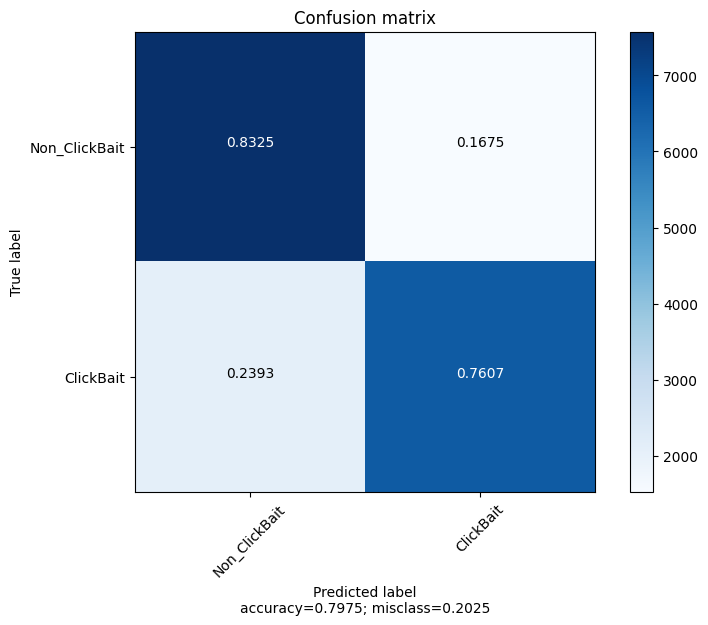

In [28]:
plot_confusion_matrix(cm=matrix1,target_names=['Non_ClickBait', 'ClickBait'])